In [84]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras

import os, pathlib, warnings
warnings.filterwarnings("ignore")
import tensorflow.keras.backend as K

from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

K.clear_session()

In [85]:
train_path = os.path.join("D:/Учёба/neironki/train")
test_path = os.path.join("D:/Учёба/neironki/test")
validation_path = os.path.join("D:/Учёба/neironki/validation")

In [86]:
def count_files(rootdir):
    for path in pathlib.Path(rootdir).iterdir():
        if path.is_dir():
            print("There are " + str(len([name for name in os.listdir(path) \
            if os.path.isfile(os.path.join(path, name))])) + " files in " + \
            str(path.name))
 
count_files(os.path.join(test_folder))

There are 110 files in airplane
There are 146 files in car
There are 133 files in cat
There are 106 files in dog
There are 127 files in flower
There are 150 files in fruit
There are 119 files in motorbike
There are 148 files in person


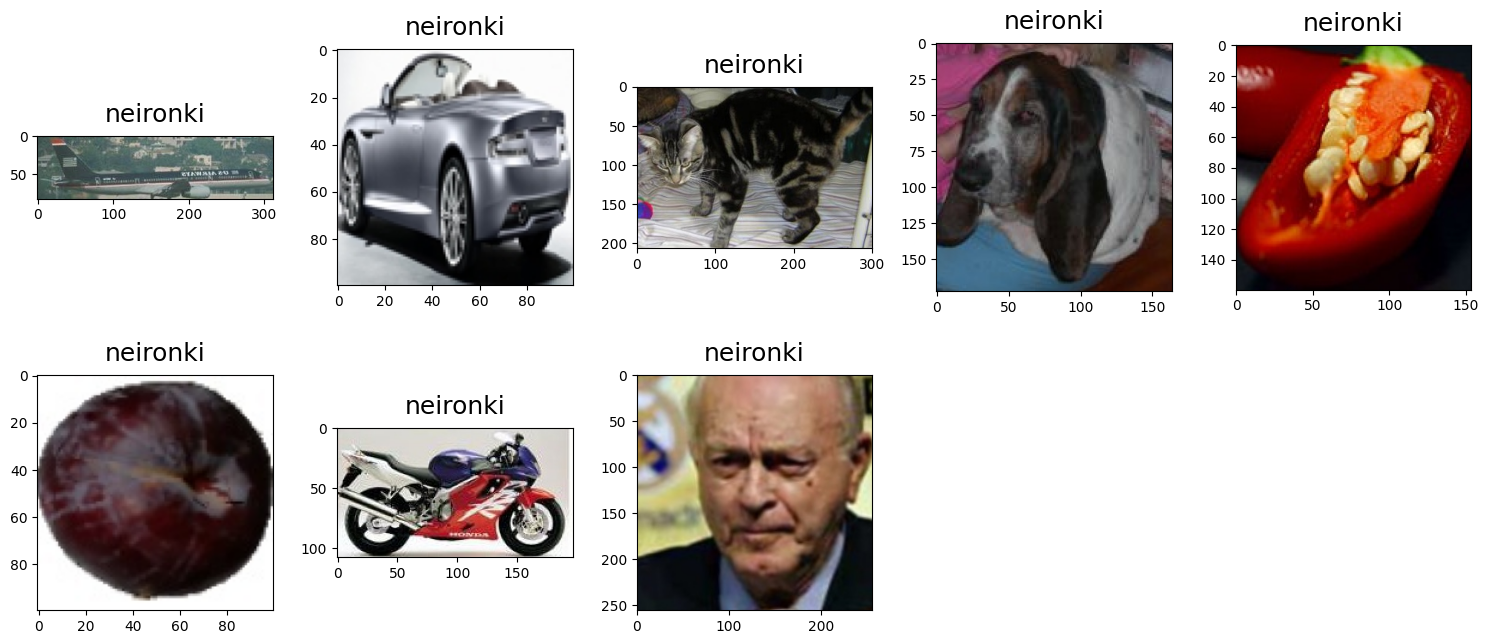

In [87]:
images = []

for food_folder in sorted(os.listdir(train_folder)):
    food_items = os.listdir(train_folder + '/' + food_folder)
    food_selected = np.random.choice(food_items)
    images.append(os.path.join(train_folder,food_folder,food_selected))
                                     
fig=plt.figure(1, figsize=(15, 10))

for subplot,image_ in enumerate(images):
    category=image_.split('/')[-2]
    imgs = plt.imread(image_)
    a,b,c=imgs.shape
    fig=plt.subplot(3, 5, subplot+1)
    fig.set_title(category, pad = 10,size=18)
    plt.imshow(imgs)
    
plt.tight_layout()

In [88]:
IMAGE_SIZE = [150, 150]

inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

for layer in inception.layers:
    layer.trainable = False

x = inception.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.2)(x)

prediction = Dense(8, activation='softmax')(x)

model = Model(inputs=inception.input, outputs=prediction)

model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [89]:
train_gen = image.ImageDataGenerator(rescale = 1.0/255.0)
train_image_generator = train_gen.flow_from_directory(
                                            train_path,
                                            target_size=(150, 150),
                                            batch_size=32,
                                            class_mode='categorical')

val_gen = image.ImageDataGenerator(rescale = 1.0/255.0)
val_image_generator = train_gen.flow_from_directory(
                                            validation_path,
                                            target_size=(150, 150),
                                            batch_size=32,
                                            class_mode='categorical')

test_gen = image.ImageDataGenerator(rescale = 1.0/255.0)
test_image_generator = train_gen.flow_from_directory(
                                            test_path,
                                            target_size=(150, 150),
                                            batch_size=32,
                                            class_mode='categorical')

Found 4826 images belonging to 8 classes.
Found 1034 images belonging to 8 classes.
Found 1039 images belonging to 8 classes.


In [90]:
class_map = training_set.class_indices
class_map

{'airplane': 0,
 'car': 1,
 'cat': 2,
 'dog': 3,
 'flower': 4,
 'fruit': 5,
 'motorbike': 6,
 'person': 7}

In [91]:
early_stopping = keras.callbacks.EarlyStopping(patience=5)
r = model.fit_generator(
    train_image_generator,
    validation_data=val_image_generator,
    epochs=10,
    verbose=1,
    steps_per_epoch = 4826//32,
    validation_steps = 1034//32,
    callbacks=early_stopping
)

Epoch 1/10
150/150 [==============================] - 38s 240ms/step - loss: 0.1640 - accuracy: 0.9524 - val_loss: 0.0514 - val_accuracy: 0.9883
Epoch 2/10
150/150 [==============================] - 36s 238ms/step - loss: 0.0410 - accuracy: 0.9881 - val_loss: 0.0362 - val_accuracy: 0.9912
Epoch 3/10
150/150 [==============================] - 35s 234ms/step - loss: 0.0189 - accuracy: 0.9948 - val_loss: 0.0205 - val_accuracy: 0.9922
Epoch 4/10
150/150 [==============================] - 35s 234ms/step - loss: 0.0111 - accuracy: 0.9960 - val_loss: 0.0468 - val_accuracy: 0.9844
Epoch 5/10
150/150 [==============================] - 35s 236ms/step - loss: 0.0100 - accuracy: 0.9969 - val_loss: 0.0238 - val_accuracy: 0.9912
Epoch 6/10
150/150 [==============================] - 35s 234ms/step - loss: 0.0052 - accuracy: 0.9977 - val_loss: 0.0392 - val_accuracy: 0.9922
Epoch 7/10
150/150 [==============================] - 35s 237ms/step - loss: 0.0180 - accuracy: 0.9944 - val_loss: 0.0242 - val_ac

In [96]:
model.save('model_inceptionV3_epoch5.h5')
model.evaluate(test_image_generator)

33/33 [==============================] - 6s 184ms/step - loss: 0.0431 - accuracy: 0.9942


[0.04305987432599068, 0.9942252039909363]

{0: 'airplane', 1: 'car', 2: 'cat', 3: 'dog', 4: 'flower', 5: 'fruit', 6: 'motorbike', 7: 'person'}
1/1 [==============================] - 0s 37ms/step


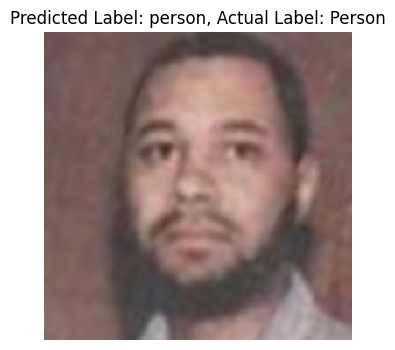

In [101]:
class_map = dict([(v, k) for k, v in train_image_generator.class_indices.items()])
print(class_map)
test_image_path = 'D:/Учёба/neironki/test/person/person_0004.jpg'

def generate_predictions(test_image_path, actual_label):

    test_img = image.load_img(test_image_path, target_size=(150, 150))
    test_img_arr = image.img_to_array(test_img)/255.0
    test_img_input = test_img_arr.reshape((1, test_img_arr.shape[0], test_img_arr.shape[1], test_img_arr.shape[2]))

    predicted_label = np.argmax(model.predict(test_img_input))
    predicted_vegetable = class_map[predicted_label]
    plt.figure(figsize=(4, 4))
    plt.imshow(test_img_arr)
    plt.title("Predicted Label: {}, Actual Label: {}".format(predicted_vegetable, actual_label))
    plt.grid()
    plt.axis('off')
    plt.show()

generate_predictions(test_image_path, actual_label='Person')

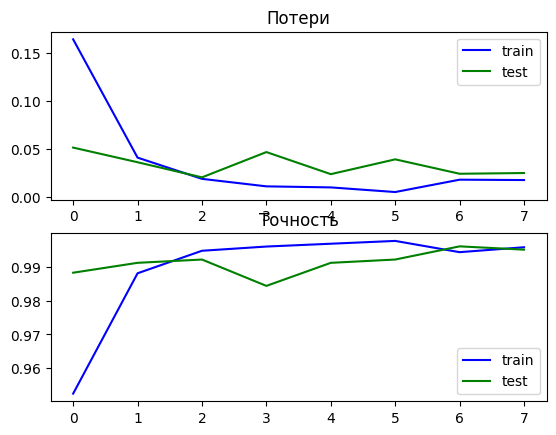

In [93]:
h = r.history
plt.subplot(211)
plt.title('Потери')
plt.plot(h['loss'], color='blue', label='train')
plt.plot(h['val_loss'], color='green', label='test')
plt.legend()

plt.subplot(212)
plt.title('Точность')
plt.plot(h['accuracy'], color='blue', label='train')
plt.plot(h['val_accuracy'], color='green', label='test')
plt.legend()
plt.show()

1/1 [==============================] - 1s 775ms/step


KeyError: 0